In [3]:
import os
 
print("username:" , os.getlogin())
from datetime import date

today = date.today()
print("Today's date:", today)
import findspark
findspark.init()

username: aghar
Today's date: 2022-11-16


In [4]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.getOrCreate()

import numpy as np

In [5]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

c:\Users\aghar\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [6]:
import os
os.getcwd()

'c:\\Users\\aghar\\Downloads'

In [7]:
from platform import python_version

print(python_version())

3.10.8


In [8]:
sc.version #spark version

'3.3.1'

In [9]:
train_df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .csv("train_smote_pca_scaled_99.csv")
print("There are",train_df.count(),"rows",len(train_df.columns),
      "columns" ,"in the data.") 
test_df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .csv("test_pca_scaled_99.csv")
print("There are",test_df.count(),"rows",len(test_df.columns),
      "columns" ,"in the data.") 

There are 58498 rows 64 columns in the data.
There are 8238 rows 64 columns in the data.


In [10]:
cols=train_df.columns

In [11]:
cols.remove('y_yes')

In [12]:
features=cols

In [13]:
dependentVariable = "y_yes"

assemblerInputs = features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vectorized_features', handleInvalid='skip')




In [14]:
stages=[]
stages+=[assembler]

In [15]:
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(train_df)

In [16]:
train_df= pipelinemodel.transform(train_df)

In [17]:
pipeline = Pipeline(stages=stages)
pipelinemodel = pipeline.fit(test_df)

In [18]:
test_df= pipelinemodel.transform(test_df)

In [71]:
from pyspark.ml.classification import FMClassifier
#lr = LogisticRegression(featuresCol = 'vectorized_features', labelCol = 'y_yes', maxIter=5)
#lr = RandomForestClassifier(numTrees=5,featuresCol = 'vectorized_features',labelCol="y_yes", seed=42)
#lr=GBTClassifier(maxIter=5, maxDepth=3, labelCol="y_yes",featuresCol = 'vectorized_features', seed=42)
#lr=DecisionTreeClassifier(maxDepth=3,labelCol="y_yes",featuresCol = 'vectorized_features', seed=42)
#lr= MultilayerPerceptronClassifier(layers=[2, 2, 2], labelCol="y_yes",featuresCol = 'vectorized_features',seed=42)
lr = FMClassifier(factorSize=2,labelCol="y_yes",featuresCol = 'vectorized_features')

In [81]:
lrModel = lr.fit(train_df)
# training ROC for the model
trainingSummary = lrModel.summary

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lrModel.setThresholds([bestThreshold,1-bestThreshold])

AttributeError: 'function' object has no attribute 'fMeasureByThreshold'

In [73]:
# confusion matrix
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 357  582]
 [ 174 7125]]


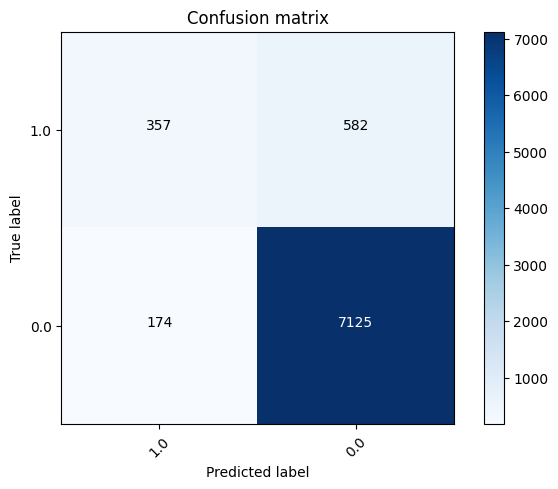

Accuracy :  0.9082301529497451


In [74]:
predictions = lrModel.transform(test_df)
predictions=predictions.withColumnRenamed("y_yes","label")
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

In [82]:
train_df.columns

['pc1',
 'pc2',
 'pc3',
 'pc4',
 'pc5',
 'pc6',
 'pc7',
 'pc8',
 'pc9',
 'pc10',
 'job_admin',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_basic_4y',
 'education_basic_6y',
 'education_basic_9y',
 'education_high_school',
 'education_illiterate',
 'education_professional_course',
 'education_university_degree',
 'education_unknown',
 'default_no',
 'default_unknown',
 'default_yes',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_o

In [99]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='vectorized_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='vectorized_features', k=i)
    
    KMeans_fit=KMeans_algo.fit(train_df)
    
    output=KMeans_fit.transform(train_df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score for {} clusters: ".format(i),score)

Silhouette Score for 2 clusters:  0.3901665603141243
Silhouette Score for 3 clusters:  0.40592975122204095
Silhouette Score for 4 clusters:  0.2663298847287042
Silhouette Score for 5 clusters:  0.258206860982
Silhouette Score for 6 clusters:  0.2724416046381056
Silhouette Score for 7 clusters:  0.261835796617096
Silhouette Score for 8 clusters:  0.25778846318858595
Silhouette Score for 9 clusters:  0.27073210701628897


In [86]:
KMeans_algo=KMeans(featuresCol='vectorized_features', k=3)
    
KMeans_fit=KMeans_algo.fit(train_df)
output=KMeans_fit.transform(train_df)

In [91]:
cluster.head()

,pc1,pc2,prediction
0,-1.600069,0.169452,0
1,-1.588052,0.306208,0
2,-1.796721,0.470207,0
3,-1.648162,-0.042371,0
4,-2.180826,0.673460,0


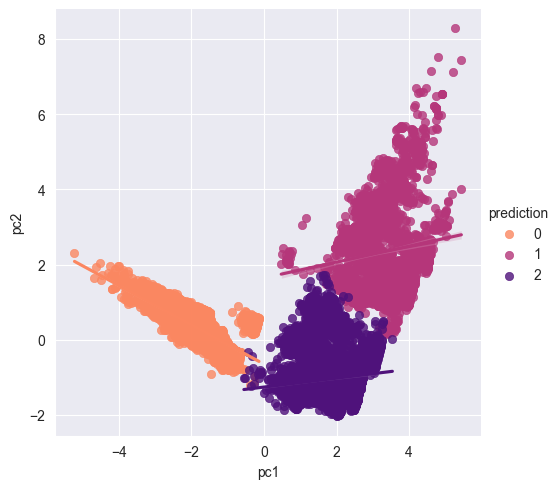

In [96]:
import seaborn as sns
cluster=output.select('pc1','pc2','prediction').toPandas()
sns.set_style('darkgrid')
sns.lmplot(data=cluster,x='pc1',y='pc2',hue='prediction',palette='magma_r')

In [85]:
print(range(2,10))

range(2, 10)


In [75]:
# testing ROC for model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9105216099598431


In [76]:
from handyspark import *

c:\Users\aghar\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under ROC Curve: 0.9105
Area under PR Curve: 0.5507


c:\Users\aghar\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

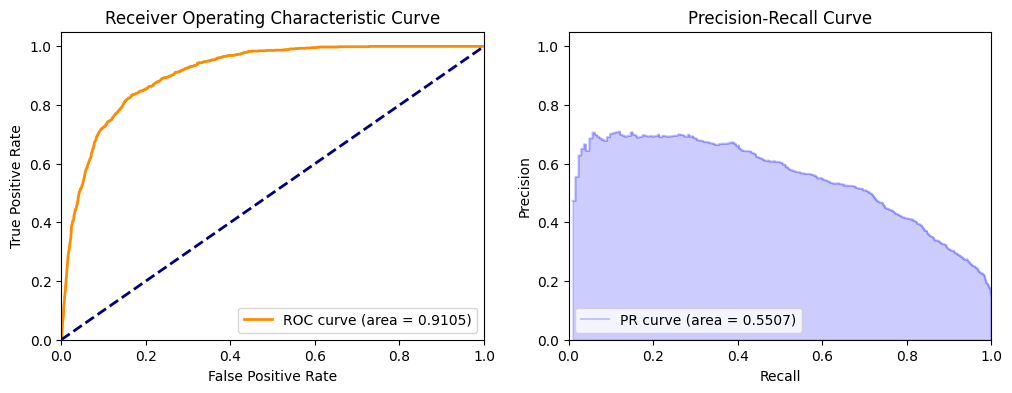

In [77]:

bcm = BinaryClassificationMetrics(predictions,scoreCol='probability', labelCol='label')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
	
print('Precision: %.3f' % precision_score(y_true, y_pred))
print('Recall: %.3f' % recall_score(y_true, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
print('F1 Score: %.3f' % f1_score(y_true, y_pred))

Precision: 0.672
Recall: 0.380
Accuracy: 0.908
F1 Score: 0.486


In [184]:
pip install spark_ml_utils


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import spark_ml_utils.LogisticRegressionModel_util as lu
#lrModel=lr.fit(train_df)
#training_pred=lrModel.transform(train_df)
lu.extract_feature_name(predictions,'vectorized_features',stat=True)

,feature_index,feature_name,N,mean,std
0,0,pc1,58498,6.332851e-13,1.954282
1,1,pc2,58498,-1.350523e-12,1.213902
2,2,pc3,58498,-1.248401e-12,1.077367
3,3,pc4,58498,2.103123e-12,1.018671
4,4,pc5,58498,-7.693342e-13,0.947854
...,...,...,...,...,...
58,58,day_of_week_tue,58498,1.286540e-01,0.334819
59,59,day_of_week_wed,58498,1.299532e-01,0.336255
60,60,poutcome_failure,58498,7.054942e-02,0.256073
61,61,poutcome_nonexistent,58498,7.424698e-01,0.437278


In [54]:
lu.feature_importance(lrm_model=lrModel
                      , trainDF=train_df, trainFeatures='vectorized_features'
                      , nonzero_only=True )

,feature_index,feature_name,coef,mean,std,std_coef,feature_importance
0,3,pc4,-1.145172,2.103123e-12,1.018671,-1.166554,1.166554
1,0,pc1,0.358309,6.332851e-13,1.954282,0.700237,0.700237
2,2,pc3,0.585395,-1.248401e-12,1.077367,0.630685,0.630685
3,5,pc6,0.667936,-6.825096e-14,0.919640,0.614261,0.614261
4,56,day_of_week_mon,-1.717875,1.310130e-01,0.337417,-0.579641,0.579641
...,...,...,...,...,...,...,...
58,47,month_dec,-1.037215,3.829191e-03,0.061762,-0.064061,0.064061
59,25,marital_unknown,-1.163763,1.111149e-03,0.033316,-0.038772,0.038772
60,7,pc8,0.073496,-6.837274e-13,0.504083,0.037048,0.037048
61,30,education_illiterate,-1.061455,2.735136e-04,0.016536,-0.017552,0.017552


In [189]:
predictions.dtypes

[('pc1', 'double'),
 ('pc2', 'double'),
 ('pc3', 'double'),
 ('pc4', 'double'),
 ('pc5', 'double'),
 ('pc6', 'double'),
 ('pc7', 'double'),
 ('pc8', 'double'),
 ('job_admin', 'int'),
 ('job_blue-collar', 'int'),
 ('job_entrepreneur', 'int'),
 ('job_housemaid', 'int'),
 ('job_management', 'int'),
 ('job_retired', 'int'),
 ('job_self-employed', 'int'),
 ('job_services', 'int'),
 ('job_student', 'int'),
 ('job_technician', 'int'),
 ('job_unemployed', 'int'),
 ('job_unknown', 'int'),
 ('marital_divorced', 'int'),
 ('marital_married', 'int'),
 ('marital_single', 'int'),
 ('marital_unknown', 'int'),
 ('education_basic_4y', 'int'),
 ('education_basic_6y', 'int'),
 ('education_basic_9y', 'int'),
 ('education_high_school', 'int'),
 ('education_illiterate', 'int'),
 ('education_professional_course', 'int'),
 ('education_university_degree', 'int'),
 ('education_unknown', 'int'),
 ('default_no', 'int'),
 ('default_unknown', 'int'),
 ('default_yes', 'int'),
 ('housing_no', 'int'),
 ('housing_unknow

In [186]:

lu.feature_importance(lrm_model=lrModel
                      , trainDF=train_df, trainFeatures='vectorized_features'
                      , nonzero_only=True )

,feature_index,feature_name,coef,mean,std,std_coef,feature_importance
0,3,pc4,-1.141797,-2.000770e-12,1.018560,-1.162989,1.162989
1,0,pc1,0.390557,-3.933060e-13,1.954194,0.763224,0.763224
2,5,pc6,0.762829,2.941357e-12,0.923782,0.704688,0.704688
3,2,pc3,0.620732,-1.248337e-12,1.080583,0.670753,0.670753
4,54,day_of_week_mon,-1.765591,1.304444e-01,0.336795,-0.594642,0.594642
...,...,...,...,...,...,...,...
56,23,marital_unknown,-1.222055,1.179951e-03,0.034330,-0.041954,0.041954
57,51,month_oct,-0.293076,2.069190e-02,0.142352,-0.041720,0.041720
58,45,month_dec,-0.634682,4.155480e-03,0.064329,-0.040829,0.040829
59,28,education_illiterate,-1.514603,2.907126e-04,0.017048,-0.025821,0.025821


In [179]:
cv_summary=cvModel.bestModel.summary
fMeasure = cv_summary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

In [180]:
bestThreshold

0.37658835325570317